![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/18.03.SentimentDetector.ipynb)

# **SentimentDetector**

This notebook will cover the different parameters and uses of `SentimentDetector`. This annotator trains a rule based sentiment detector, which calculates a score based on predefined keywords. 




**📖 Learning Objectives:**

1. Understand how `SentimentDetector's` rule-based system works.

2. Understand how `SentimentDetector` can be used to get predictions about the sentiment in a text.

3. Become comfortable using the different parameters of the annotator.


**🔗 Helpful Links:**

- Documentation : [SentimentDetector](https://nlp.johnsnowlabs.com/docs/en/annotators#sentimentdetector)

- Python Docs : [SentimentDetector](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/sentiment/sentiment_detector/index.html#)

- Scala Docs : [SentimentDetector](https://nlp.johnsnowlabs.com/api/com/johnsnowlabs/nlp/annotators/sda/pragmatic/SentimentDetector.html)

- For extended examples of usage, see the [Spark NLP Workshop repository](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/training/english/dictionary-sentiment/sentiment.ipynb).


## **📜 Background**

`Sentiment Analysis` is a sub-field of NLP that measures the inclination of people’s opinions within the unstructured text.

`SentimentDetector` uses a rule-based approach, which is a practical approach to analyzing text without training or using machine learning models. In the case discussed below, result of this approach is a set of rules based on which the text is labeled as (Positive / Negative / Neutral), but in some cases the result may be much simpler as either `positive` or `negative`.

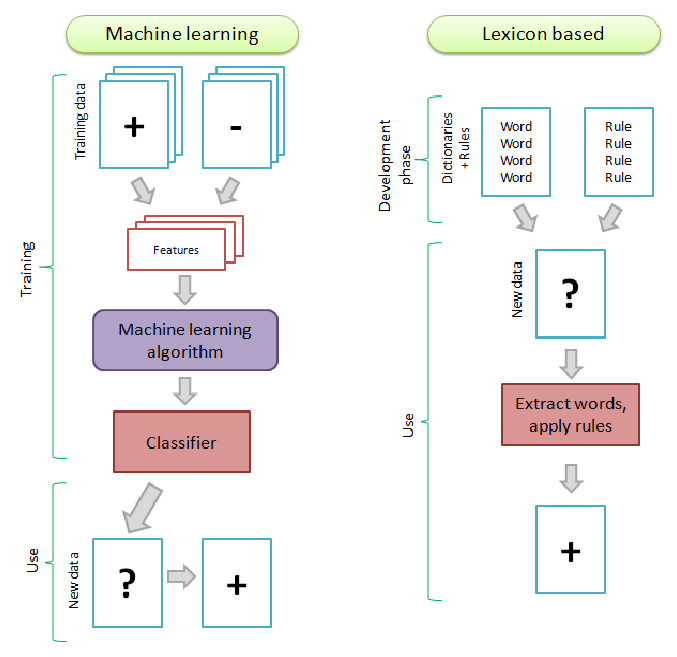

<br/>

A dictionary of predefined sentiment keywords must be provided with setDictionary, where each line is a word delimited to its class (either positive or negative). The dictionary can be set either in the form of a delimited text file or directly as an ExternalResource.

By default, the sentiment score will be assigned labels "positive" if the score is >= 0, else "negative". To retrieve the raw sentiment scores, enableScore needs to be set to true.




## **🎬 Colab Setup**

In [1]:
!pip install -q pyspark==3.1.2  spark-nlp==4.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 15.1 MB/s eta 0:00:00


In [2]:
import sparknlp

import sys
sys.path.append('../../')

import sparknlp
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import array_contains
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import DocumentAssembler, Finisher

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.1.2


## **🖨️ Input/Output Annotation Types**

- Input: `TOKEN`, `DOCUMENT`

- Output: `SENTIMENT`

## **🔎 Parameters**

- `setDictionary`: (path: str) Delimited file with a list sentiment tags per word. Requires 'delimiter' in options.   

- `setEnableScore`: (Boolean) If true, score will show as the double value, else will output string "positive" or "negative" (Default: false).

- `setDecrementMultiplier`: Multiplier for decrement sentiments (Default: -2.0).

- `setIncrementMultiplier`: Multiplier for increment sentiments (Default: 2.0).

- `setNegativeMultiplier`: Multiplier for negative sentiments (Default: -1.0).

- `setPositiveMultiplier`: Multiplier for positive sentiments (Default: 1.0).

- `setReverseMultiplier`: Multiplier for revert sentiments (Default: -1.0).


## **💻 SentimentDetector Pipeline**

In [3]:
# Load the Dataset, Lemmas and the Sentiment Dictionary

! rm /tmp/sentiment.parquet.zip
! rm -rf /tmp/sentiment.parquet
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/lemma-corpus-small/lemmas_small.txt -P /tmp
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/default-sentiment-dict.txt -P /tmp    

rm: cannot remove '/tmp/sentiment.parquet.zip': No such file or directory
--2023-02-16 15:19:34--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/lemma-corpus-small/lemmas_small.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.187.53, 52.216.92.133, 52.216.12.22, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.187.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189437 (185K) [text/plain]
Saving to: ‘/tmp/lemmas_small.txt’

lemmas_small.txt    100%[===================>] 185.00K  --.-KB/s    in 0.05s   

2023-02-16 15:19:34 (3.29 MB/s) - ‘/tmp/lemmas_small.txt’ saved [189437/189437]

--2023-02-16 15:19:34--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/default-sentiment-dict.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.187.53, 52.216.92.133, 52.216.12.22, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.187.53|:443... connected.
HTTP request sen

In [4]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("/tmp/default-sentiment-dict.txt", ",")
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["sentiment"])

pipeline = Pipeline(stages = [document_assembler,
                              sentence_detector,
                              tokenizer,
                              lemmatizer,
                              sentiment_detector,
                              finisher])


In [ ]:
data = spark.createDataFrame([["The restaurant staff is really nice"]]).toDF("text")

pipeline.fit(data).transform(data).show(truncate = 50)

+-----------------------------------+----------+
|                               text| sentiment|
+-----------------------------------+----------+
|The restaurant staff is really nice|[positive]|
+-----------------------------------+----------+



In [ ]:
data = spark.createDataFrame([["I recommend others to avoid because it is too expensive"]]).toDF("text")

pipeline.fit(data).transform(data).show(truncate = 50)

+--------------------------------------------------+----------+
|                                              text| sentiment|
+--------------------------------------------------+----------+
|I recommend others to avoid because it is too e...|[negative]|
+--------------------------------------------------+----------+



In [ ]:
sentiment_detector.extractParamMap()

{Param(parent='SentimentDetector_6e11f1ae83c6', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='SentimentDetector_6e11f1ae83c6', name='positiveMultiplier', doc='multiplier for positive sentiments. Defaults 1.0'): 1.0,
 Param(parent='SentimentDetector_6e11f1ae83c6', name='negativeMultiplier', doc='multiplier for negative sentiments. Defaults -1.0'): -1.0,
 Param(parent='SentimentDetector_6e11f1ae83c6', name='incrementMultiplier', doc='multiplier for increment sentiments. Defaults 2.0'): 2.0,
 Param(parent='SentimentDetector_6e11f1ae83c6', name='decrementMultiplier', doc='multiplier for decrement sentiments. Defaults -2.0'): -2.0,
 Param(parent='SentimentDetector_6e11f1ae83c6', name='reverseMultiplier', doc='multiplier for revert sentiments. Defaults -1.0'): -1.0,
 Param(parent='SentimentDetector_6e11f1ae83c6', name='enableScore', doc='if true, score will show as the double value, else will output string "positive" or "ne

### `setEnableScore`

Setting `setEnableScore` to True will display the sentiment score.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("/tmp/default-sentiment-dict.txt", ",")\
    .setEnableScore(True)
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["sentiment"])

pipeline = Pipeline(stages = [document_assembler,
                              sentence_detector,
                              tokenizer,
                              lemmatizer,
                              sentiment_detector,
                              finisher])


In [ ]:
data = spark.createDataFrame([["The staff of the restaurant is nice"]]).toDF("text")

pipeline.fit(data).transform(data).show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|The staff of the ...|    [1.0]|
+--------------------+---------+



In [ ]:
data = spark.createDataFrame([["I recommend others to avoid because it is too expensive"]]).toDF("text")

pipeline.fit(data).transform(data).show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|I recommend other...|   [-2.0]|
+--------------------+---------+



### `setPositiveMultiplier`

This parameter will multiply the positive sentiments with the specified parameter.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("/tmp/default-sentiment-dict.txt", ",")\
    .setEnableScore(True)\
    .setPositiveMultiplier(5)
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["sentiment"])

pipeline = Pipeline(stages = [document_assembler,
                              sentence_detector,
                              tokenizer,
                              lemmatizer,
                              sentiment_detector,
                              finisher])


In [ ]:
data = spark.createDataFrame([["The staff of the restaurant is nice"]]).toDF("text")

pipeline.fit(data).transform(data).show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|The staff of the ...|    [5.0]|
+--------------------+---------+



### `setNegativeMultiplier`

This parameter will multiply the negative sentiments with the specified parameter.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("/tmp/default-sentiment-dict.txt", ",")\
    .setEnableScore(True)\
    .setNegativeMultiplier(-5)
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["sentiment"])

pipeline = Pipeline(stages = [document_assembler,
                              sentence_detector,
                              tokenizer,
                              lemmatizer,
                              sentiment_detector,
                              finisher])


In [ ]:
data = spark.createDataFrame([["I recommend others to avoid because it is too expensive"]]).toDF("text")

pipeline.fit(data).transform(data).show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|I recommend other...|  [-10.0]|
+--------------------+---------+



### `setIncrementMultiplier`

This parameter will multiply the increment sentiments with the specified parameter.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("/tmp/default-sentiment-dict.txt", ",")\
    .setEnableScore(True)\
    .setIncrementMultiplier(10)
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["sentiment"])

pipeline = Pipeline(stages = [document_assembler,
                              sentence_detector,
                              tokenizer,
                              lemmatizer,
                              sentiment_detector,
                              finisher])


In [ ]:
data = spark.createDataFrame([["I really like the new design of your website! It is very nice."]]).toDF("text")

pipeline.fit(data).transform(data).show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|I really like the...|   [10.0]|
+--------------------+---------+



### `setDecrementMultiplier`

This parameter will multiply the decrement sentiments with the specified parameter.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("/tmp/default-sentiment-dict.txt", ",")\
    .setEnableScore(True)\
    .setDecrementMultiplier(-10)
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["sentiment"])

pipeline = Pipeline(stages = [document_assembler,
                              sentence_detector,
                              tokenizer,
                              lemmatizer,
                              sentiment_detector,
                              finisher])


In [ ]:
data = spark.createDataFrame([["I recommend others to avoid because it is too expensive"]]).toDF("text")

pipeline.fit(data).transform(data).show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|I recommend other...|   [-2.0]|
+--------------------+---------+



## 💾 **Applying on a Dataframe** 

We used a totally different dataset in order to check the efficiency of the model. 

In [5]:
!wget -q aclimdb_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_test.csv 

In [6]:
testDataset = spark.read \
      .option("header", True) \
      .csv("aclimdb_test.csv")

testDataset.show(truncate = 100)

+----------------------------------------------------------------------------------------------------+--------+
|                                                                                                text|   label|
+----------------------------------------------------------------------------------------------------+--------+
|The Second Woman is about the story of a mysterious man who lost his wife in an accident and now ...|negative|
|In my opinion the directing, editing, lighting, and acting(minus Franco) were very good. I must a...|positive|
|I am listening to Istanbul, intent, my eyes closed: At first there is a gentle breeze And the lea...|positive|
|Before I speak my piece, I would like to make a few things clear: 1)I am a chick who's not into c...|negative|
|ManBearPig is a pretty funny episode of South Park.It spoofs Al Gore and his speeches on Global w...|positive|
|A buddy and I went to see this movie when it came out in 1980. It was playing in a huge theater a...|ne

In [7]:
testDataset.count()

25000

In [8]:
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("/tmp/default-sentiment-dict.txt", ",")\
    .setEnableScore(False)\
    .setPositiveMultiplier(1.0)\
    .setNegativeMultiplier(-1.0)\
    .setIncrementMultiplier(2.0)\
    .setDecrementMultiplier(-2.0)
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["sentiment"])

pipeline = Pipeline(stages = [document_assembler,
                              sentence_detector,
                              tokenizer,
                              lemmatizer,
                              sentiment_detector,
                              finisher])

In [9]:
empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = pipeline.fit(empty_df)

In [14]:
%%time
pipelineModel.transform(testDataset).show(6, truncate = 100)

+----------------------------------------------------------------------------------------------------+--------+----------+
|                                                                                                text|   label| sentiment|
+----------------------------------------------------------------------------------------------------+--------+----------+
|The Second Woman is about the story of a mysterious man who lost his wife in an accident and now ...|negative|[positive]|
|In my opinion the directing, editing, lighting, and acting(minus Franco) were very good. I must a...|positive|[positive]|
|I am listening to Istanbul, intent, my eyes closed: At first there is a gentle breeze And the lea...|positive|[positive]|
|Before I speak my piece, I would like to make a few things clear: 1)I am a chick who's not into c...|negative|[positive]|
|ManBearPig is a pretty funny episode of South Park.It spoofs Al Gore and his speeches on Global w...|positive|[positive]|
|A buddy and I w